# HCML project

## Finetuning VGG16

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import os
import cv2
from more_itertools import chunked
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
SEED = 78
BATCH_SIZE = 64
IMG_SIZE = 256 

In [3]:
def prepare_data(ds, training):
    normalization = layers.Rescaling(1./255)
    ds = ds.map(lambda x, y: (normalization(x), y))

    if training:
        brightness = layers.RandomBrightness((-0.3, 0.3), value_range=(0., 1.), seed=SEED)
        rotation = layers.RandomRotation(0.2, seed=SEED)

        rotated_ds = ds.map(lambda x, y: (rotation(x), y))
        brightness_ds = ds.map(lambda x, y: (brightness(x), y))
        rotated_brightness_ds = ds.map(lambda x, y: (brightness(rotation(x)), y))
                
        ds = tf.data.Dataset.sample_from_datasets(
                [ds, rotated_ds, brightness_ds, rotated_brightness_ds]
        )

    return ds.batch(BATCH_SIZE)

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/sorted-heysem-dataset/sorted_data/train",
    validation_split=0.3,
    label_mode='binary',
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=None,
#     batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/sorted-heysem-dataset/sorted_data/train",
    validation_split=0.3,
    label_mode='binary',
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=None,
#     batch_size=BATCH_SIZE
)

train_ds = prepare_data(train_ds, training=True)
val_ds = prepare_data(val_ds, training=False)

#NOTE: the output here is incorrect and there is no verbose option...

Found 8100 files belonging to 2 classes.
Using 5670 files for training.
Found 8100 files belonging to 2 classes.
Using 2430 files for validation.


In [5]:
vgg=VGG16(include_top=False, pooling='avg', weights='imagenet', input_shape=(256, 256, 3))

# Freeze the layers except the last 5
for layer in vgg.layers[:-5]:
    layer.trainable = False
# # Check the trainable status of the individual layers
# for layer in vgg.layers:
#     print(layer, layer.trainable)


# Model
model = keras.Sequential() # Add the VGG16 convolutional base model
model.add(vgg)
 
# Add new layers
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])


58889256/58889256 [==============================] - 2s 0us/step


In [6]:
early = EarlyStopping(monitor='val_acc', 
                      patience=5, 
                      verbose=1, 
                      mode='auto')

hist = model.fit(x=train_ds,
                 validation_data=val_ds,
                 # 5670 normal images, each of which is augmented thr
#                  steps_per_epoch=5670 * 4 // BATCH_SIZE,
                 epochs=50,
                 callbacks=[early]
                )

Epoch 1/50
355/355 [==============================] - 189s 475ms/step - loss: 0.3348 - binary_accuracy: 0.8590 - val_loss: 6.3338 - val_binary_accuracy: 0.4523
Epoch 2/50
355/355 [==============================] - 167s 459ms/step - loss: 0.2381 - binary_accuracy: 0.9086 - val_loss: 0.3129 - val_binary_accuracy: 0.8885
Epoch 3/50
355/355 [==============================] - 159s 435ms/step - loss: 0.1940 - binary_accuracy: 0.9263 - val_loss: 0.2166 - val_binary_accuracy: 0.9193
Epoch 4/50
355/355 [==============================] - 169s 465ms/step - loss: 0.1671 - binary_accuracy: 0.9391 - val_loss: 0.6140 - val_binary_accuracy: 0.8021
Epoch 5/50
355/355 [==============================] - 168s 461ms/step - loss: 0.1488 - binary_accuracy: 0.9451 - val_loss: 0.4755 - val_binary_accuracy: 0.8379
Epoch 6/50
355/355 [==============================] - 165s 453ms/step - loss: 0.1308 - binary_accuracy: 0.9512 - val_loss: 0.3765 - val_binary_accuracy: 0.8905
Epoch 7/50
355/355 [====================

In [7]:
model.save('/kaggle/working/model_v1_5.h5')

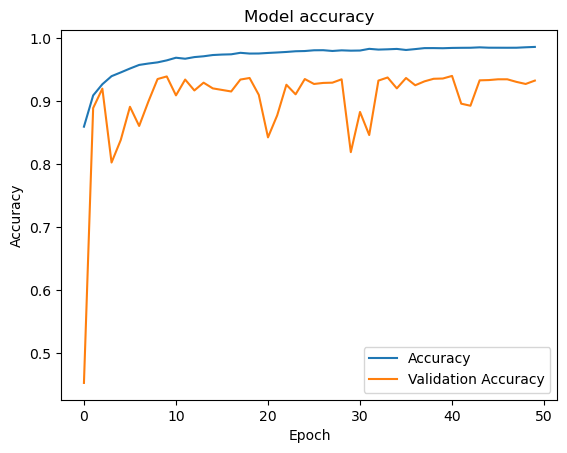

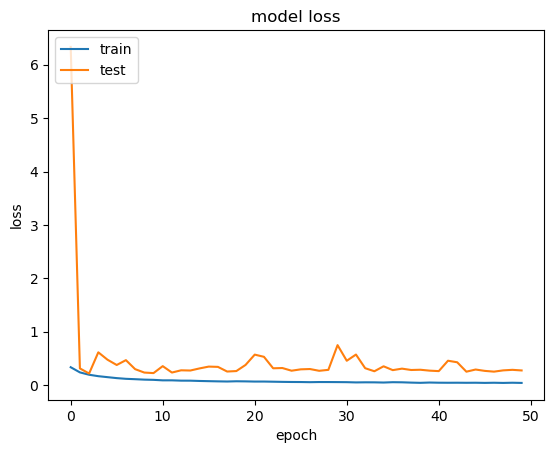

In [8]:
import matplotlib.pyplot as plt
plt.plot(hist.history["binary_accuracy"])
plt.plot(hist.history['val_binary_accuracy'])
# plt.plot(hist.history['loss'])
# plt.plot(hist.history['val_loss'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
meta_data = pd.read_csv("/kaggle/input/meta-data/eth_gender_anno_all.xlsx - eth_gender_trait_annotations_de.csv")
# use same encoding 
meta_data['Gender'] = meta_data["Gender"].replace(2, 0)

# clear difference in occurences in data
meta_data["Ethnicity"].value_counts()

2    8598
3    1071
1     331
Name: Ethnicity, dtype: int64

In [10]:
# test_ds = tf.keras.utils.image_dataset_from_directory(
#     "/kaggle/input/sorted-heysem-dataset/sorted_data/test",
#     label_mode='binary',
#     seed=SEED,
#     image_size=(IMG_SIZE, IMG_SIZE),
#     batch_size=None,
# #     batch_size=BATCH_SIZE
# )
# test_ds = prepare_data(test_ds, training=False)

In [11]:
def load_and_preprocess_image(image_path):
    # NOTE: ensure this matches the original model
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0  # Normalize pixel values
    return img

In [12]:
src = "/kaggle/input/sorted-heysem-dataset/sorted_data/test/"
women_paths = [os.path.join(src, "woman/", file) for file in os.listdir(src + "woman/")]# if file.endswith('.JPG')]
men_paths = [os.path.join(src, "man/", file) for file in os.listdir(src + "man/")]# if file.endswith('.JPG')]

women_data = [load_and_preprocess_image(path) for path in women_paths]
men_data = [load_and_preprocess_image(path) for path in men_paths]

women_batches = chunked(women_data, BATCH_SIZE)
men_batches = chunked(men_data, BATCH_SIZE)

In [13]:
w_predictions = []
for batch in women_batches:
    dataset = tf.data.Dataset.from_tensor_slices(batch).batch(64)

    # because sigmoid output of one node
    preds = model.predict(dataset) < 0.5 
    w_predictions.append(preds.astype(int))

1/1 [==============================] - 0s 38ms/step


In [14]:
m_predictions = []
for batch in men_batches:
    dataset = tf.data.Dataset.from_tensor_slices(batch).batch(64)

    # because sigmoid output of one node
    preds = model.predict(dataset) < 0.5 
    m_predictions.append(preds.astype(int))

1/1 [==============================] - 5s 5s/step


In [15]:
w_preds = [i[0] for pred in w_predictions for i in pred]
m_preds = [i[0] for pred in m_predictions for i in pred]

In [16]:
results_dict = {}

for pred, path in zip(w_preds, women_paths):
    trim_path = path[-23:-4]
    row = meta_data.loc[meta_data["VideoName"] == trim_path]
    
    ethnicity, gender = tuple(row[["Ethnicity", "Gender"]].values[0])

    results_dict[trim_path] = (pred, ethnicity, gender)

In [17]:
df = pd.DataFrame.from_dict(results_dict).T
df.columns = ["gender_prediction", "ethnicity", "gender_true"]
print(df.shape)
df.head()

(1112, 3)


,gender_prediction,ethnicity,gender_true
bYXRyimxh7A.001.mp4,0,2,0
aaylz9A9K80.002.mp4,0,2,0
mlXZQ8dO0nQ.000.mp4,0,2,0
J6RHl6U6Jcw.003.mp4,0,2,0
Vj-Cmtqv_qY.004.mp4,0,2,0


WOMEN


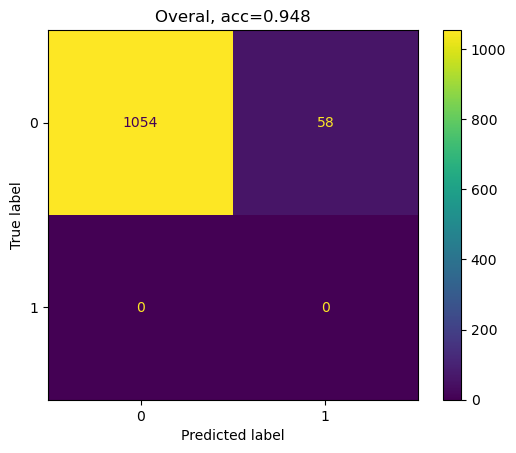

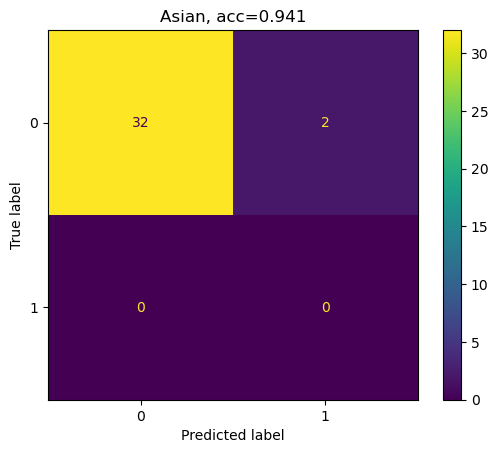

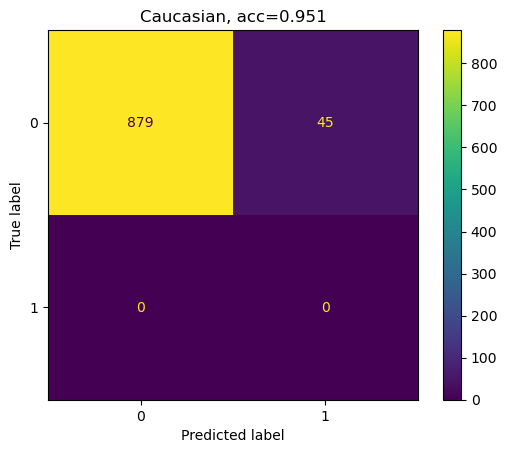

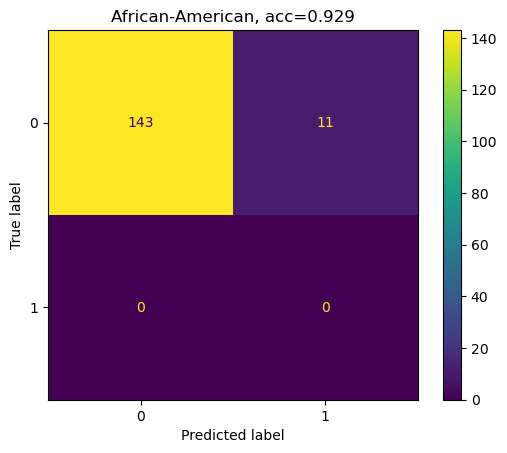

In [18]:
# index to ethnicity according to orignal dataset
i2e = {1: "Asian", 2:"Caucasian", 3:"African-American"}

print("WOMEN")
acc = round(sum(df['gender_prediction'] == df['gender_true'])/len(df), 3)
cm = confusion_matrix(df["gender_true"], df["gender_prediction"])
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title(f"Overal, acc={acc}")
plt.show()

for e in i2e.keys():
    e_df = df.loc[df['ethnicity']==e]
    
    acc = round(sum(e_df['gender_prediction'] == e_df['gender_true'])/len(e_df), 3)

    cm = confusion_matrix(e_df["gender_true"], e_df["gender_prediction"])
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.title(f"{i2e[e]}, acc={acc}")
    plt.show()

In [19]:
results_dict = {}

for pred, path in zip(m_preds, men_paths):
    trim_path = path[-23:-4]
    row = meta_data.loc[meta_data["VideoName"] == trim_path]
    
    ethnicity, gender = tuple(row[["Ethnicity", "Gender"]].values[0])

    results_dict[trim_path] = (pred, ethnicity, gender)

In [20]:
df = pd.DataFrame.from_dict(results_dict).T
df.columns = ["gender_prediction", "ethnicity", "gender_true"]
print(df.shape)
df.head()

(888, 3)


,gender_prediction,ethnicity,gender_true
0G2o3fik36I.001.mp4,1,2,1
SkNO4x-LSgE.003.mp4,1,2,1
PTV5TBVRHxo.004.mp4,1,2,1
IL5VgGakSNw.002.mp4,1,2,1
VUGWfw5PVLY.001.mp4,1,2,1


MEN


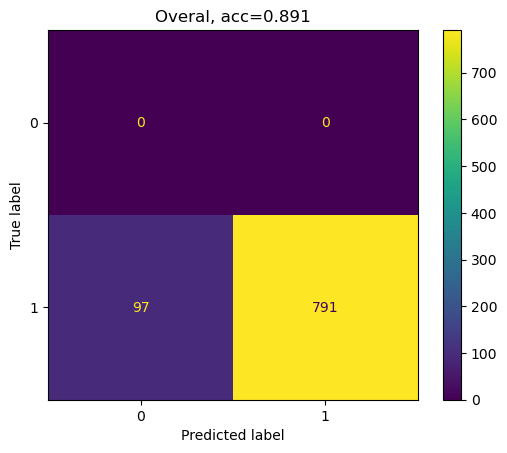

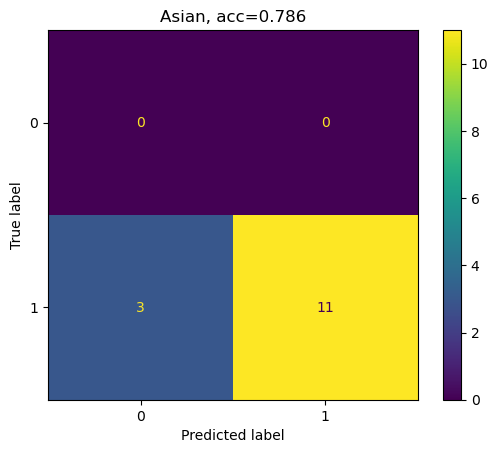

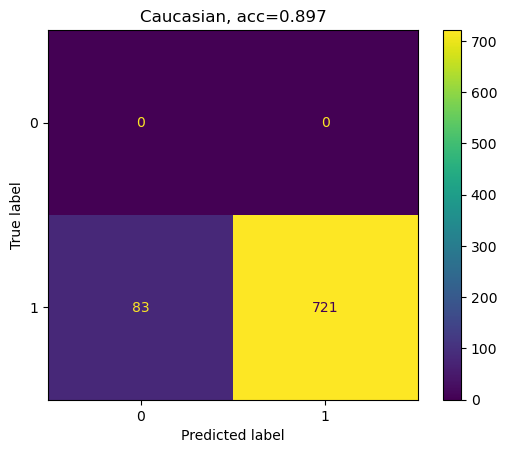

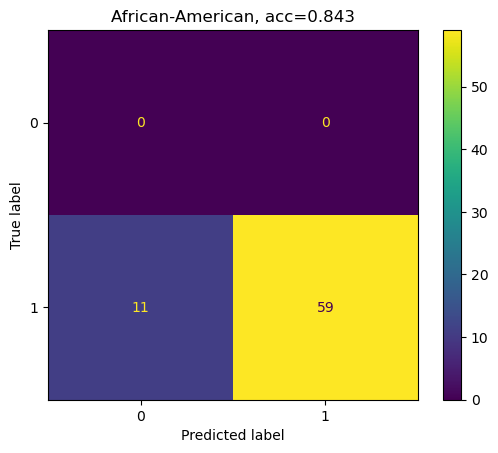

In [21]:
# index to ethnicity according to orignal dataset
i2e = {1: "Asian", 2:"Caucasian", 3:"African-American"}

print("MEN")
acc = round(sum(df['gender_prediction'] == df['gender_true'])/len(df), 3)
cm = confusion_matrix(df["gender_true"], df["gender_prediction"])
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title(f"Overal, acc={acc}")
plt.show()

for e in i2e.keys():
    e_df = df.loc[df['ethnicity']==e]
    
    acc = round(sum(e_df['gender_prediction'] == e_df['gender_true'])/len(e_df), 3)

    cm = confusion_matrix(e_df["gender_true"], e_df["gender_prediction"])
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.title(f"{i2e[e]}, acc={acc}")
    plt.show()

## Archive
storing some stuff that we might still use

In [22]:
# TO PLOT IMAGE
# count = 0 
# # for batch in all_ds[2]:
# for batch in b:

#     count += 1
#     img = batch[0].numpy()#.astype("uint8")
#     plt.imshow(img)
#     plt.show()
    
#     if count > 10: break
        

        # output_path = '/kaggle/working/output'

# checkpoint = ModelCheckpoint(filepath=output_path, 
#                              monitor='val_acc', 
#                              verbose=1, 
#                              save_best_only=True, 
#                              save_weights_only=False, 
#                              mode='auto', 
#                              period=1)


# test_ds = tf.keras.utils.image_dataset_from_directory(
#     "/kaggle/input/sorted-heysem-dataset/sorted_data/test",
#     label_mode='binary',
#     seed=SEED,
#     image_size=(IMG_SIZE, IMG_SIZE),
#     batch_size=None,
# #     batch_size=BATCH_SIZE
# )
# test_ds = prepare_data(test_ds, training=False)

# preds = model.predict(test_ds) >= 0.5 # because sigmoid output of one node
# preds = preds.astype(int)
    